# Анализ эффективности вариантов посадочной страницы на основе результатов A/B-тестирования

Проект проводится в туристической компании, которая планирует увеличить продажи туров с помощью новой акции. В рамках инициативы разработаны два варианта посадочной страницы официального сайта и проведено A/B-тестирование, в результате которого собраны данные для последующего анализа.

Задача проекта — провести всесторонний анализ эксперимента по двум основным метрикам: конверсии покупок и ежедневному среднему чеку. Помимо проверки корректности проведения теста, важно убедиться в стабилизации метрик во времени и выявить, какой из вариантов посадочной страницы более эффективен с точки зрения повышения конверсии и среднего чека.

Представлены варианты туров и их стоимости для анализа:

- Таиланд — 100 000 рублей  
- Турция — 60 000 рублей  
- Мальдивы — 200 000 рублей  
- Санкт-Петербург — 10 000 рублей  
- Камчатка — 150 000 рублей  

In [29]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import DescrStatsW
import statsmodels.api as sm


In [30]:
df = pd.read_csv('C:/Users/admin/Desktop/$/DS_education/DS_PROD-4_AB-тестирование/ab_data_tourist.csv')
data = df.copy()
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


1. Анализ структуры данных и предобработка

1.1. Ознакомление со структурой данных

In [ ]:
# Исследование структуры
print(f'Размер данных: {data.shape}')
print('Информация о данных:')
print(data.info())
print('Проверка пропусков по колонкам:')
print(data.isnull().sum())

Размер данных: (294478, 5)
Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB
None
Проверка пропусков по колонкам:
user_id     0
date        0
group       0
purchase    0
price       0
dtype: int64
Первые 5 строк:
   user_id        date group  purchase   price
0   851104  2021-01-21     A         0       0
1   804228  2021-01-12     A         0       0
2   661590  2021-01-11     B         0       0
3   853541  2021-01-08     B         0       0
4   864975  2021-01-21     A         1  150000


1.2. Преобразование типов данных

- Преобразовать колонку date в формат datetime
- Убедиться, что user_id — строковый тип (для надёжного сравнения)
- Колонки purchase и price привести к целочисленному типу

In [32]:
# Преобразование типов
data['date'] = pd.to_datetime(data['date'])
data['user_id'] = data['user_id'].astype(str)
data['purchase'] = data['purchase'].astype(int)
data['price'] = data['price'].astype(int)

1.3. Сравнение длительности теста в группах и её уравнивание

- Определить минимальные и максимальные даты для групп А и В
- Урезать данные до пересечения периодов (чтобы длительность совпала)

In [33]:
# Проверка длительности теста по группам
dates_by_group = data.groupby('group')['date'].agg(['min', 'max'])
print('Даты проведения теста в группах:')
print(dates_by_group)

# Уравнивание периодов
start_date = dates_by_group['min'].max()
end_date = dates_by_group['max'].min()
print(f'Общий период теста: с {start_date.date()} по {end_date.date()}')

data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

Даты проведения теста в группах:
             min        max
group                      
A     2021-01-02 2021-01-24
B     2021-01-02 2021-01-24
Общий период теста: с 2021-01-02 по 2021-01-24


1.4. Подсчёт ключевых показателей по группам

- Количество посещений сайта (общее число строк) по группам А и B
- Суммарное количество покупок по группам
- Сумма всех покупок по группам (перевести в миллионы рублей и округлить)

In [34]:
# Подсчёт ключевых показателей
visits_by_group = data.groupby('group')['user_id'].count()
purchases_by_group = data.groupby('group')['purchase'].sum()
revenue_by_group = data.groupby('group')['price'].sum() / 1_000_000  # в миллионах

print('Количество посещений сайта по группам:')
print(visits_by_group)
print('Суммарное количество покупок по группам:')
print(purchases_by_group)
print('Сумма всех покупок по группам (в млн рублей):')
print(revenue_by_group.round(2))

Количество посещений сайта по группам:
group
A    147202
B    147276
Name: user_id, dtype: int64
Суммарное количество покупок по группам:
group
A    17723
B    17514
Name: purchase, dtype: int64
Сумма всех покупок по группам (в млн рублей):
group
A    1436.26
B    1554.10
Name: price, dtype: float64


1.5. Проверка пользователей, попавших в обе тестовые группы

- Создать множества пользователей каждого варианта
- Найти пересечение (уникальных пользователей в обеих группах)
- Вывести число таких пользователей
- Исключить их из анализа (создать очищенный датафрейм для дальнейшей работы)

In [35]:
# Проверка пересечения пользователей
users_A = set(data.loc[data['group'] == 'A', 'user_id'])
users_B = set(data.loc[data['group'] == 'B', 'user_id'])

user_intersection = users_A.intersection(users_B)
num_intersection = len(user_intersection)
print(f'Количество пользователей в обеих группах: {num_intersection}')

# Исключение пользователей, попавших в обе группы
updated_data = data[~data['user_id'].isin(user_intersection)]

print(f'Размер данных после исключения пользователей из обеих групп: {updated_data.shape}')

Количество пользователей в обеих группах: 1895
Размер данных после исключения пользователей из обеих групп: (290688, 5)


Первичные выводы по анализу данных и предобработке

- Данные содержат 294 478 записей с полной информацией по всем пяти столбцам, пропущенных значений не обнаружено.
- Даты проведения A/B-тестирования совпадают для обеих групп и охватывают период с 2 по 24 января 2021 года, что обеспечивает равные условия теста.
- Количество посещений сайта в группах A и B сопоставимо: около 147 тысяч в каждой группе, что говорит о сбалансированности выборок.
- По числу совершённых покупок также наблюдается близкий результат — чуть более 17 тысяч покупок в каждой группе.
- Общая сумма покупок в группе B немного выше (около 1,55 млрд рублей) по сравнению с группой A (около 1,44 млрд рублей).
- Выявлено 1 895 пользователей, которые участвовали в обеих группах, их данные были исключены для предотвращения искажения результатов.
- После очистки от пересекающихся пользователей размер датасета составляет 290 688 записей, что незначительно меньше исходного объёма.

Эти выводы подтверждают корректность структуры и качества данных, а также адекватность длительности и распределения теста для дальнейшего анализа эффективности посадочных страниц.

2. Первичный анализ результатов A/B-тестирования

2.1. Расчёт основных показателей по группам

- Группировка данных по колонке group с подсчётом:
- количества посещений сайта (count_visits)
- суммарного количества совершённых покупок (count_purchases)
- суммы всех покупок (sum_price)

- Переименование столбцов для удобочитаемости.

In [36]:
# Группировка с подсчётом основных показателей
group_data = updated_data.groupby('group').agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index()

# 2.1. Переименование столбцов
rename_group_data = group_data.rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
})

print('Основные показатели по группам:')
print(rename_group_data)

Основные показатели по группам:
  group  count_visits  count_purchases   sum_price
0     A        145307            17487  1417780000
1     B        145381            17290  1533010000


2.2. Анализ сбалансированности выборок

- Сравнение количества посещений групп A и B
- Вывод по поводу сбалансированности выборок на основе этого показателя

In [37]:
# Сравнение количества посещений
visits_A = rename_group_data.loc[rename_group_data['group'] == 'A', 'count_visits'].values[0]
visits_B = rename_group_data.loc[rename_group_data['group'] == 'B', 'count_visits'].values[0]

print(f'Количество посещений сайта в группе A: {visits_A}')
print(f'Количество посещений сайта в группе B: {visits_B}')

Количество посещений сайта в группе A: 145307
Количество посещений сайта в группе B: 145381


2.3. Вычисление ключевых метрик: конверсии и среднего чека

- Конверсия: отношение количества покупок к количеству посещений
- Средний чек: отношение суммы покупок к количеству покупок

In [38]:
# Расчёт конверсии и среднего чека
rename_group_data['conversion'] = rename_group_data['count_purchases'] / rename_group_data['count_visits']
rename_group_data['avg_check'] = rename_group_data['sum_price'] / rename_group_data['count_purchases']
rename_group_data['avg_check'] = rename_group_data['avg_check'].fillna(0)

print('Ключевые показатели (конверсия и средний чек):')
print(rename_group_data[['group', 'conversion', 'avg_check']])

Ключевые показатели (конверсия и средний чек):
  group  conversion     avg_check
0     A    0.120345  81076.228055
1     B    0.118929  88664.545980


 Первичные выводы по результатам A/B-тестирования

- Конверсия в группе A чуть выше — около 12,03% против 11,89% в группе B, что свидетельствует о незначительно лучшей способности варианта A превращать посетителей в покупателей.
- Средний чек в группе B выше — около 88 665 рублей против 81 076 рублей в группе A, что указывает на больший средний размер покупки у пользователей варианта B.
- Таким образом, вариант A демонстрирует преимущество по показателю конверсии, тогда как вариант B выигрывает по среднему чеку.
- Общая эффективность каждого варианта зависит от бизнес-целей: если важнее увеличить количество покупателей, предпочтителен вариант A; если важен больший доход с каждого покупателя — вариант B.
- Для комплексного решения стоит учитывать оба показателя и продолжить анализ, например, с учётом распределения заказов по турам и потенциального влияния разных сегментов покупателей.

2.4. Сравнение покупательской способности по турам

- Построение сводной таблицы по количеству покупок, сгруппированных по цене тура и тестовой группе
- Построение визуализации для наглядного сравнения групп по различным ценовым сегментам туров

Сводная таблица по количеству покупок в зависимости от цены тура и группы:
group      A     B
price             
10000   5182  5201
60000   5271  1730
100000  1832  5227
150000  3478  3438
200000  1724  1694


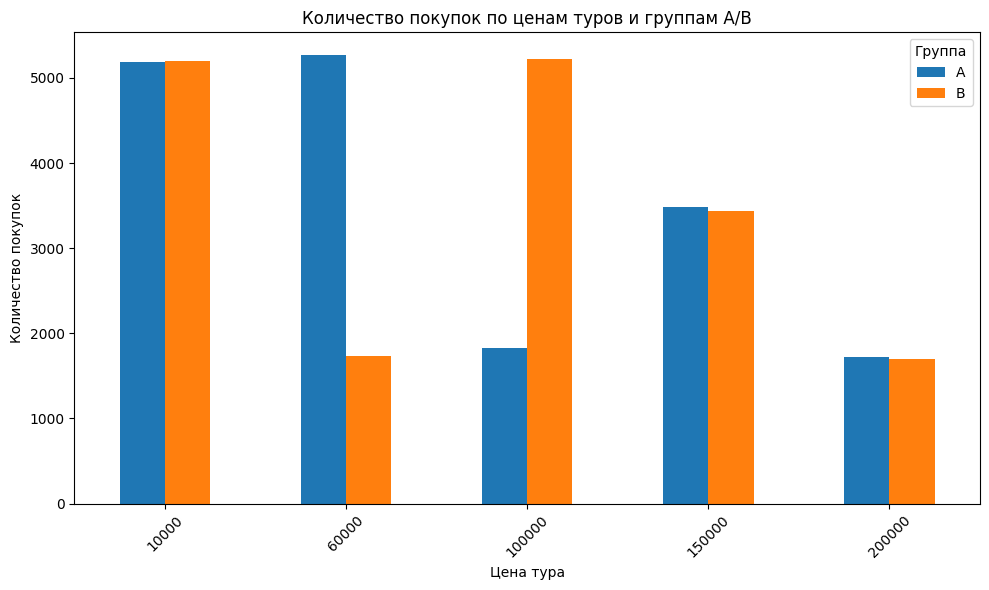

In [39]:
# Анализ покупательской способности по турам

# Создание сводной таблицы с количеством покупок по цене тура и группам
pivot_tours = updated_data[updated_data['purchase'] == 1].pivot_table(
    index='price',
    columns='group',
    values='purchase',
    aggfunc='count',
    fill_value=0
).sort_index()

print('Сводная таблица по количеству покупок в зависимости от цены тура и группы:')
print(pivot_tours)

# Визуализация сводной таблицы
pivot_tours.plot(kind='bar', figsize=(10, 6))
plt.title('Количество покупок по ценам туров и группам A/B')
plt.xlabel('Цена тура')
plt.ylabel('Количество покупок')
plt.xticks(rotation=45)
plt.legend(title='Группа')
plt.tight_layout()
plt.show()

На основании представленных данных можно сделать следующие выводы о покупательской способности участников групп A и B:

1. Группа A:

   - Участники группы A чаще покупают туры стоимостью 10 и 60 тыс. руб. Это указывает на то, что они предпочитают более доступные варианты.
   - В категории туров стоимостью 100000 руб. количество покупок в группе A ниже, чем в группе B.

2. Группа B:

   - Участники группы B чаще покупают туры стоимостью 10000 и 100000 руб. Это может свидетельствовать о том, что они готовы тратить больше на туры.
   - В категории туров стоимостью 10 и 60 тыс. руб. количество покупок в группе B ниже, чем в группе A.

3. Сопоставимые значения:

   - В категориях туров стоимостью 150000 и 200000 руб. количество покупок в группах A и B сопоставимо.

Таким образом, при одинаковых количествах проданных туров, выручка в группе B будет выше, так как они чаще покупают более дорогие туры.

3. Анализ стабилизации метрик

3.1. Группировка данных по дате и группе, расчет ежедневных показателей

- Количество посещений страницы (число записей) в каждой группе и в каждый день
- Количество покупок
- Сумма покупок

In [40]:
# Группируем данные по дате и группе
daily_metrics = updated_data.groupby(['date', 'group']).agg(
    daily_visits=('user_id', 'count'),
    daily_purchases=('purchase', 'sum'),
    daily_revenue=('price', 'sum')
).reset_index()

3.2. Добавление в таблицу ежедневной конверсии и среднего чека

- Ежедневная конверсия = число покупок / число посещений
- Ежедневный средний чек = сумма покупок / число покупок



In [41]:
# Ежедневные показатели: конверсия и средний чек
daily_metrics['daily_conversion'] = daily_metrics['daily_purchases'] / daily_metrics['daily_visits']
daily_metrics['daily_avg_check'] = daily_metrics.apply(
    lambda row: row['daily_revenue'] / row['daily_purchases'] if row['daily_purchases'] > 0 else 0,
    axis=1)

3.3. Вычисление кумулятивных показателей по группам

- Кумулятивное количество посещений
- Кумулятивное количество покупок
- Кумулятивная сумма покупок

In [42]:
# Расчет кумулятивных показателей для каждой группы
daily_metrics = daily_metrics.sort_values(['group', 'date'])

daily_metrics['cum_visits'] = daily_metrics.groupby('group')['daily_visits'].cumsum()
daily_metrics['cum_purchases'] = daily_metrics.groupby('group')['daily_purchases'].cumsum()
daily_metrics['cum_revenue'] = daily_metrics.groupby('group')['daily_revenue'].cumsum()

3.4. Расчёт кумулятивной конверсии и среднего чека

- Кумулятивная конверсия = кумулятивное число покупок / кумулятивное число посещений
- Кумулятивный средний чек = кумулятивная сумма покупок / кумулятивное число покупок

In [43]:
# Кумулятивные конверсия и средний чек
daily_metrics['cum_conversion'] = daily_metrics['cum_purchases'] / daily_metrics['cum_visits']
daily_metrics['cum_avg_check'] = daily_metrics.apply(
    lambda row: row['cum_revenue'] / row['cum_purchases'] if row['cum_purchases'] > 0 else 0,
    axis=1
)

3.5. Визуализация кумулятивных показателей

- Построение графиков кумулятивной конверсии и среднего чека для групп A и B по дням

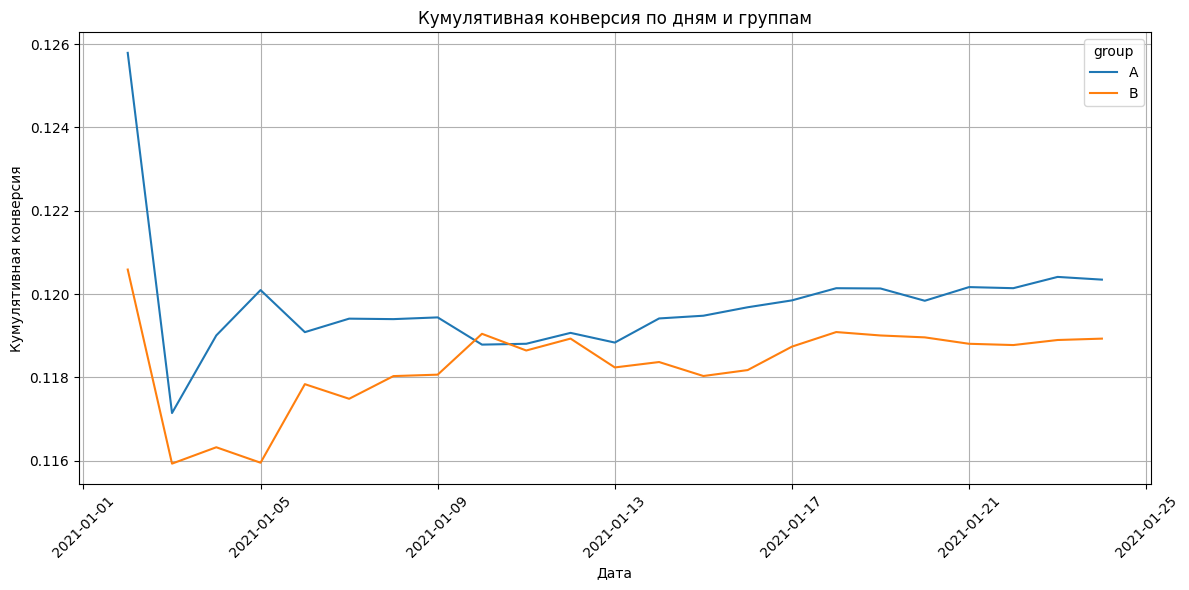

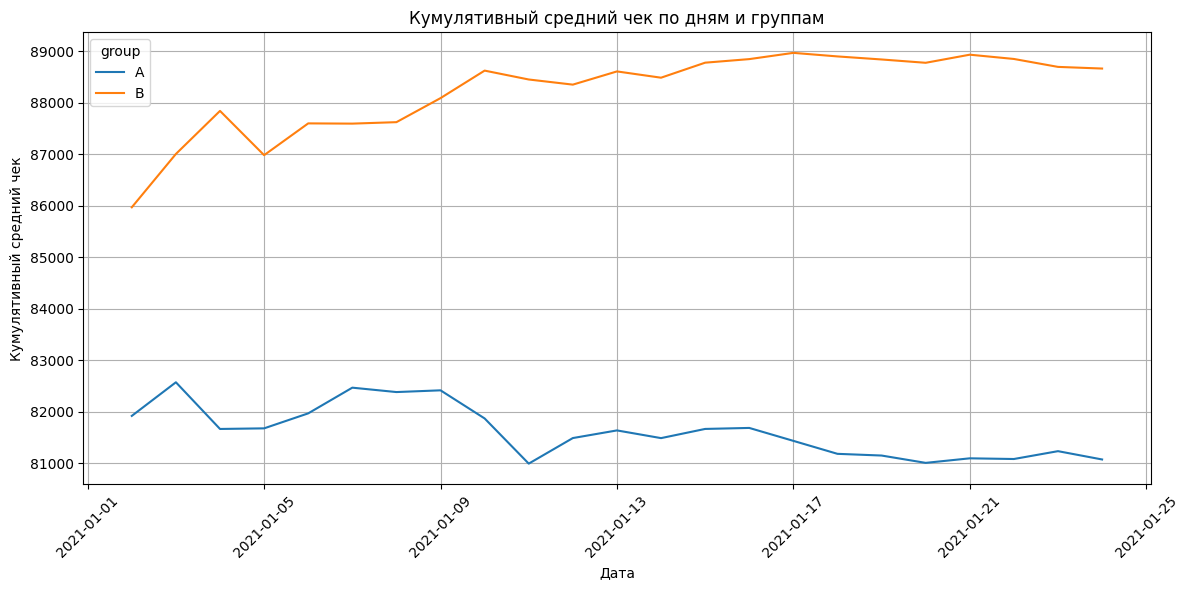

In [44]:
# Визуализация кумулятивной конверсии
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_metrics, x='date', y='cum_conversion', hue='group')
plt.title('Кумулятивная конверсия по дням и группам')
plt.ylabel('Кумулятивная конверсия')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Визуализация кумулятивного среднего чека
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_metrics, x='date', y='cum_avg_check', hue='group')
plt.title('Кумулятивный средний чек по дням и группам')
plt.ylabel('Кумулятивный средний чек')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Выводы:
- Кумулятивная конверсия в группе A стабильно выше, чем в группе B, на всём протяжении теста, за исключением 10 января, когда произошло временное снижение.
- Пиковые значения конверсии в обеих группах наблюдаются в первый день теста (2 января), после чего следует резкий спад к 3 января и постепенная стабилизация.
- Значения кумулятивной конверсии обеих групп стабилизировались примерно после 15 января, что говорит о снижении колебаний и достижении стабильных показателей.
- Средний чек у группы B стабильно выше, чем у группы A на протяжении всего периода.
- Кроме того, динамика среднего чека показывает рост в группе B, тогда как в группе A наблюдается постепенное снижение.
- На основе данных трендов можно заключить, что метрики стабилизировались, и тест достиг стабильного результата.
- Следовательно, тест можно считать завершённым, и результаты можно использовать для принятия решений о выборе более эффективной версии посадочной страницы.

4. Статистический анализ результатов A/B-тестирования

4.1. Формулировка гипотез и выбор тестов

- **Гипотезы для конверсии**  
  - H0 (нулевая гипотеза): Конверсия в группе A равна конверсии в группе B  
  - H1 (альтернативная гипотеза): Конверсия в группе A и B различаются  
  - Тест: z-тест для разности долей (конверсий) или тест хи-квадрат для независимых выборок

- **Гипотезы для среднего чека**  
  - H0: Средний чек в группе A равен среднему чеку в группе B  
  - H1: Средние чеки в группах отличаются  
  - Для проверки нормальности данных используем тест Шапиро или визуальную проверку (гистограмма, Q-Q plot)  
  - При нормальном распределении — t-тест для двух независимых выборок  
  - Если распределение не нормальное — непараметрический тест Мана-Уитни

4.2. Проверка нормальности данных

In [45]:
# Средние чеки по дням для групп A и B
avg_check_A = daily_metrics[daily_metrics['group']=='A']['daily_avg_check']
avg_check_B = daily_metrics[daily_metrics['group']=='B']['daily_avg_check']

# Тест Шапиро
stat_A, p_A = shapiro(avg_check_A)
stat_B, p_B = shapiro(avg_check_B)

print(f'Группа A: Shapiro-Wilk p-value = {p_A}')
print(f'Группа B: Shapiro-Wilk p-value = {p_B}')

Группа A: Shapiro-Wilk p-value = 0.25307406517246855
Группа B: Shapiro-Wilk p-value = 0.09378219197381865


4.3. Статистический тест для конверсий (z-тест для долей)

In [46]:
# Конверсия - успехи (число покупок) и наблюдения (число посещений) по группам
successes = rename_group_data['count_purchases'].values
nobs = rename_group_data['count_visits'].values

stat, pval = proportions_ztest(successes, nobs)
print(f'z-тест для конверсий: статистика = {stat:.4f}, p-value = {pval:.4f}')

z-тест для конверсий: статистика = 1.1765, p-value = 0.2394


4.4. Статистический тест для ежедневных средних чеков (t-тест или Манна-Уитни)

In [47]:
# Если данные в задаче нормальны, используем t-тест
t_stat, t_pval = ttest_ind(avg_check_A, avg_check_B, equal_var=False)
print(f't-тест для среднего чека: t-статистика = {t_stat:.4f}, p-value = {t_pval:.4f}')

# Если Shapiro показал ненормальность, используйте непараметрический тест
u_stat, u_pval = mannwhitneyu(avg_check_A, avg_check_B)
print(f'Тест Манна-Уитни для среднего чека: U-статистика = {u_stat:.4f}, p-value = {u_pval:.4f}')

t-тест для среднего чека: t-статистика = -9.6091, p-value = 0.0000
Тест Манна-Уитни для среднего чека: U-статистика = 3.0000, p-value = 0.0000


4.5. Построение 95% доверительных интервалов

- Для конверсий используем формулу для пропорций.
- Для разницы конверсий — метод Вилсона или нормальное приближение.
- Для среднего чека — доверительный интервал через среднее и стандартную ошибку.

In [48]:
# Доверительный интервал для конверсий в группе A и B
confint_A = sm.stats.proportion_confint(rename_group_data.loc[rename_group_data['group']=='A', 'count_purchases'].values[0],
                                       rename_group_data.loc[rename_group_data['group']=='A', 'count_visits'].values[0],
                                       alpha=0.05, method='wilson')
confint_B = sm.stats.proportion_confint(rename_group_data.loc[rename_group_data['group']=='B', 'count_purchases'].values[0],
                                       rename_group_data.loc[rename_group_data['group']=='B', 'count_visits'].values[0],
                                       alpha=0.05, method='wilson')

print(f'95% доверительный интервал для конверсии группы A: {confint_A}')
print(f'95% доверительный интервал для конверсии группы B: {confint_B}')

95% доверительный интервал для конверсии группы A: (0.11868230810530649, 0.12202816544000698)
95% доверительный интервал для конверсии группы B: (0.11727498180653662, 0.12060292287595631)


Вычисления стандартных ошибок конверсий и построения доверительного интервала для разницы конверсий, а также для доверительных интервалов среднего чека

In [50]:
# Значения конверсий и объемы выборок по группам
conv_A = rename_group_data.loc[rename_group_data['group']=='A', 'conversion'].values[0]
conv_B = rename_group_data.loc[rename_group_data['group']=='B', 'conversion'].values[0]
visits_A = rename_group_data.loc[rename_group_data['group']=='A', 'count_visits'].values[0]
visits_B = rename_group_data.loc[rename_group_data['group']=='B', 'count_visits'].values[0]

# Разница конверсий
diff_conv = conv_A - conv_B

# Вычисление стандартных ошибок для конверсий в каждой группе
se_A = np.sqrt(conv_A * (1 - conv_A) / visits_A)
se_B = np.sqrt(conv_B * (1 - conv_B) / visits_B)

# Стандартная ошибка для разницы конверсий
se_diff = np.sqrt(se_A**2 + se_B**2)

# Критическое значение z для 95% доверительного интервала
z_critical = 1.96

# Нижняя и верхняя границы доверительного интервала для разницы конверсий
diff_lower = diff_conv - z_critical * se_diff
diff_upper = diff_conv + z_critical * se_diff

print(f'Разница конверсий: {diff_conv:.5f}')
print(f'95% доверительный интервал для разницы конверсий: ({diff_lower:.5f}, {diff_upper:.5f})')

Разница конверсий: 0.00142
95% доверительный интервал для разницы конверсий: (-0.00094, 0.00378)


In [51]:
# Доверительные интервалы для среднего чека
# Сбор данных ежедневных средних чеков по группам (пример)
avg_check_A = daily_metrics[daily_metrics['group']=='A']['daily_avg_check']
avg_check_B = daily_metrics[daily_metrics['group']=='B']['daily_avg_check']

dsw_A = DescrStatsW(avg_check_A)
ci_avg_check_A = dsw_A.tconfint_mean()

dsw_B = DescrStatsW(avg_check_B)
ci_avg_check_B = dsw_B.tconfint_mean()

print(f'95% доверительный интервал для среднего чека в группе A: ({round(ci_avg_check_A[0])}, {round(ci_avg_check_A[1])})')
print(f'95% доверительный интервал для среднего чека в группе B: ({round(ci_avg_check_B[0])}, {round(ci_avg_check_B[1])})')

95% доверительный интервал для среднего чека в группе A: (79630, 82308)
95% доверительный интервал для среднего чека в группе B: (87626, 89526)


Общий вывод по результатам A/B-теста

- Конверсия  
  Z-тест показал, что статистически значимой разницы в конверсии между группами A и B нет (p-value = 0.2394 > 0.05).  
  Доверительные интервалы конверсий в обеих группах перекрываются, а интервал разницы конверсий включает 0. Это подтверждает отсутствие значимой разницы в способности обеих версий посадочной страницы превращать посетителей в покупателей.

- Средний чек  
  Тесты (t-тест и непараметрический тест Манна-Уитни) дают нулевую p-value, что указывает на статистически значимую разницу в среднем чеке между группами.  
  Группа B демонстрирует существенно более высокий средний чек, что подтверждается неперекрывающимися 95% доверительными интервалами. Средний чек группы B заметно выше (приблизительно от 87 626 до 89 526 рублей) по сравнению с группой A (от 79 630 до 82 308 рублей).

### Вывод о более эффективном варианте

- Несмотря на сходную конверсию, значительно более высокий средний чек в группе B делает вариант посадочной страницы B более эффективным с точки зрения общей выручки и дохода.  
- Если бизнес-цель — максимизация дохода, лучше выбрать страницу варианта B.  
- Если же акцент ставится сугубо на привлечении большого количества покупателей, то по конверсии явного преимущества нет.